## wgan

In [7]:
import torch
import torch.nn as nn

# ~ dcgan

class Discriminator (nn.Module):
    def __init__(self, input_channels, features) -> None:
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(input_channels, features, kernel_size=(4,4), stride=(2,2), padding=(1,1)),
            nn.LeakyReLU(0.2),
            self._convblock(features, features*2, (4,4), (2,2), (1,1)),
            self._convblock(features*2, features*4, (4,4), (2,2), (1,1)),
            self._convblock(features*4, features*8, (4,4), (2,2), (1,1)),
            nn.Conv2d(features*8, 1, kernel_size=(4,4), stride=(2,2), padding=(0,0))
        )

    def _convblock(slef, input_channels, output_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.layers(x)

class Generator (nn.Module):
    def __init__(self, z_dim, input_channels, features) -> None:
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            self._convblock(z_dim, features*16, (4,4), (1,1), (0,0)),
            self._convblock(features*16, features*8, (4,4), (2,2), (1,1)),
            self._convblock(features*8, features*4, (4,4), (2,2), (1,1)),
            self._convblock(features*4, features*2, (4,4), (2,2), (1,1)),
            nn.ConvTranspose2d(features*2, input_channels, (4,4), (2,2), (1,1)),
            nn.Tanh()
        )

    def _convblock(self, input_channels, output_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(output_channels),
            nn.ReLU()   
        )

    def forward(self, x):
        return self.layers(x)

def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)   #as described in paper

## test

In [8]:
z_dim = 100
x = torch.rand((10, 3, 64, 64))
z = torch.rand((10, z_dim, 1, 1))

dis = Discriminator(3, 8)
init_weights(dis)
gen = Generator(z_dim, 3, 8)
init_weights(gen)

print(dis(x).shape)
print(gen(z).shape)
assert dis(x).shape == (10, 1, 1, 1)
assert gen(z).shape == (10, 3, 64, 64)

torch.Size([10, 1, 1, 1])
torch.Size([10, 3, 64, 64])


## data

In [9]:
import torchvision
import torchvision.transforms as transforms

print(f'CUDA available: {torch.cuda.is_available()}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 5e-5
z_dim = 100
img_dim = 64
batch_size = 64
epochs = 5
features_dis = 64
features_gen = 64
critic_iterations = 5
weight_clip = 0.01

t = transforms.Compose([
    transforms.Resize(img_dim),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.MNIST(root='./mnist/', train=True, download=False, transform=t)
dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

dis = Discriminator(input_channels=1, features=features_dis).to(device)
gen = Generator(z_dim=z_dim, input_channels=1, features=features_gen).to(device)
init_weights(dis)
init_weights(gen)

optim_dis = torch.optim.RMSprop(dis.parameters(), lr=lr)
optim_gen = torch.optim.RMSprop(gen.parameters(), lr=lr)


CUDA available: True


## train

Epoch 0: dloss -1093.52001953125     gloss 495.449462890625


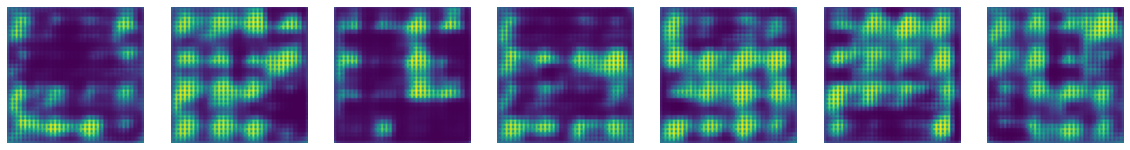

Epoch 1: dloss -3876.6982421875     gloss 1758.964599609375


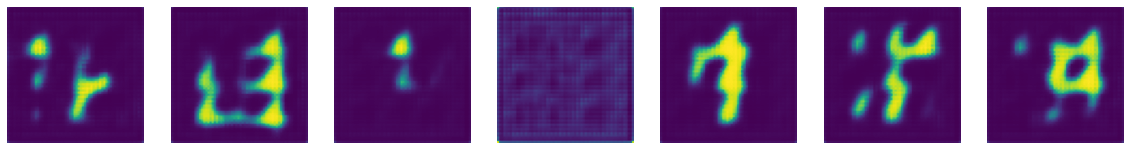

Epoch 2: dloss -7484.15966796875     gloss 3397.888671875


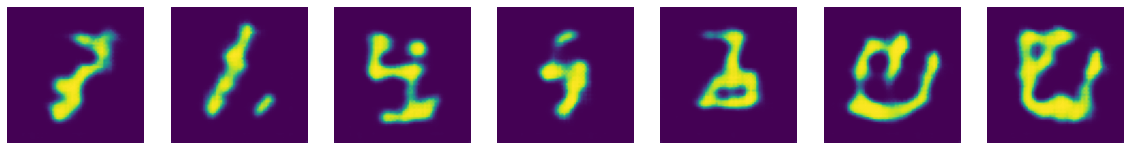

Epoch 3: dloss -13197.2431640625     gloss 6017.53515625


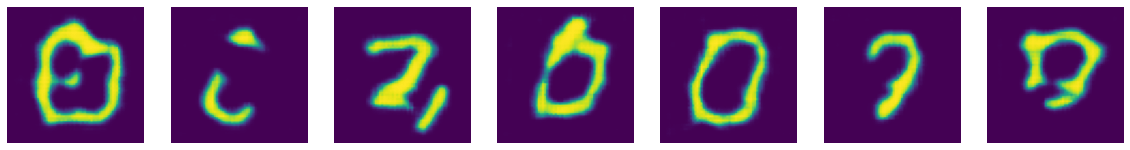

Epoch 4: dloss -6406.6982421875     gloss 6314.53515625


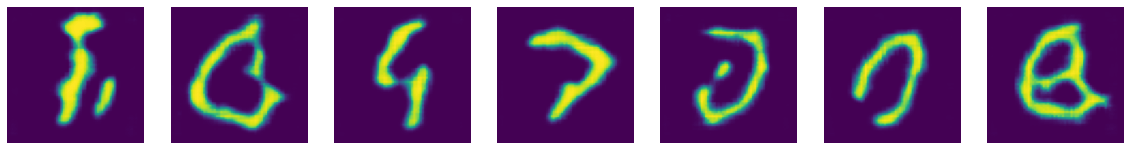

In [10]:
import matplotlib.pyplot as plt
import numpy

dlosses, glosses = [], []
fixed_noise = torch.randn(7, z_dim, 1, 1).to(device)

for epoch in range(epochs):
    for idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        
        # critic (discriminator) iterations
        for _ in range(critic_iterations):
            noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
            fake = gen(noise)
            dis_real = dis(real).reshape(-1)
            dis_fake = dis(fake).reshape(-1)
            loss_dis = -(torch.mean(dis_real)-torch.mean(dis_fake))
            dis.zero_grad()
            loss_dis.backward(retain_graph=True)
            optim_dis.step()

        # generator
        output = dis(fake).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        optim_gen.step()

        if idx%5 == 0:
            dlosses.append(loss_dis.detach().item())
            glosses.append(loss_gen.detach().item())
    
    
    print(f'Epoch {epoch}: dloss {loss_dis}     gloss {loss_gen}')

    # visualize
    fake = gen(noise)
    fig, axs = plt.subplots(1, 7, figsize=(20,20))

    for i in range(7):
        data = fake[i].cpu().detach().numpy()
        axs[i].imshow(data.reshape(64,64))
    for ax in axs:
        ax.axis('off')

    plt.show()
    

torch.Size([100, 1, 64, 64])


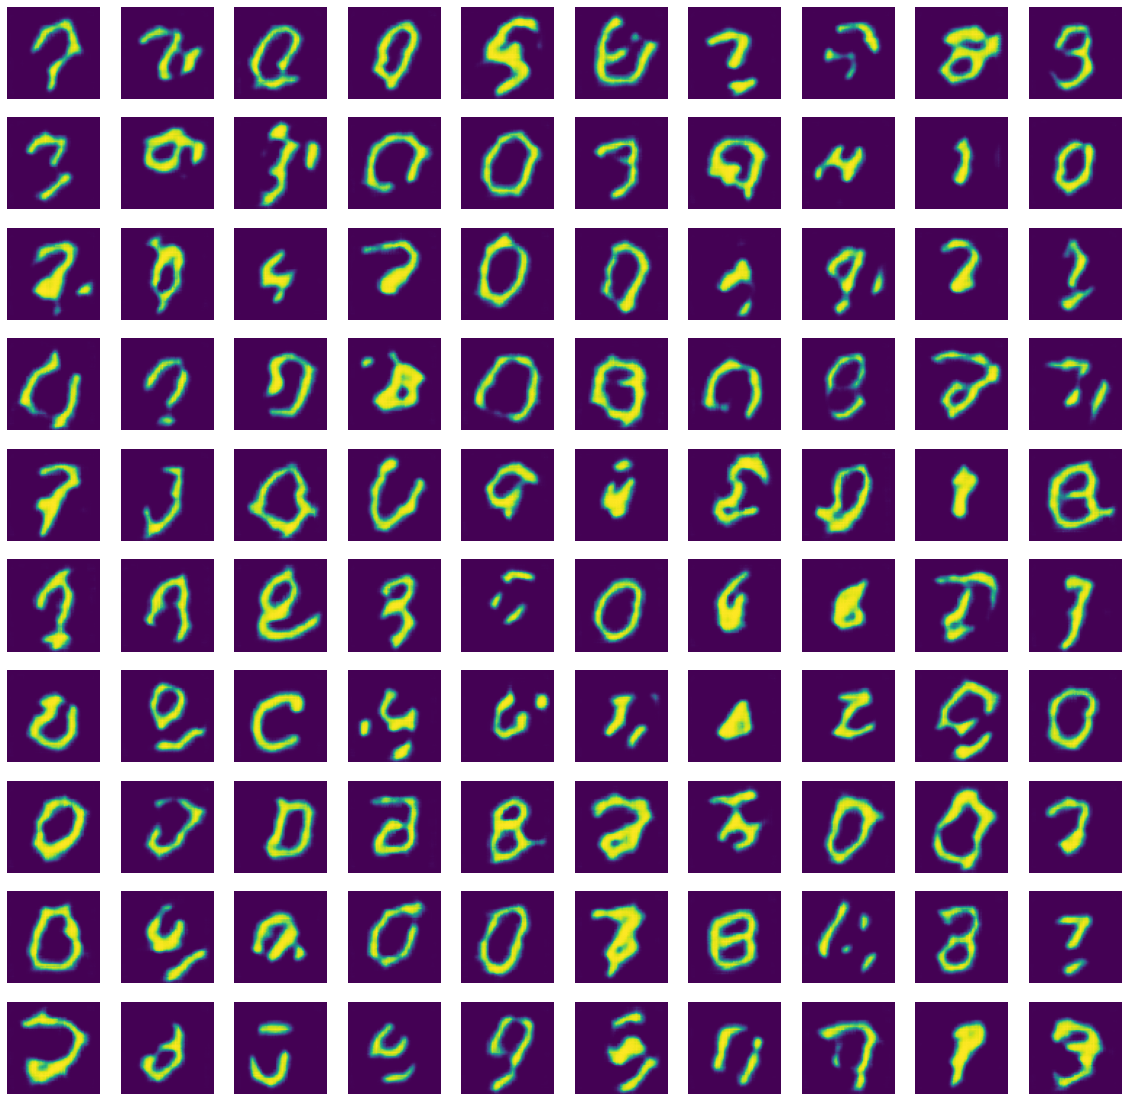

In [11]:
import matplotlib.pyplot as plt
import numpy

noise = torch.randn(100, z_dim, 1, 1).to(device)
fake = gen(noise)
print(fake.shape)
fig, axs = plt.subplots(10, 10, figsize=(20,20))
for i, ax in enumerate(axs.flat):
    data = fake[i].cpu().detach().numpy()
    ax.imshow(data.reshape(64,64))
    ax.axis('off')

plt.show()

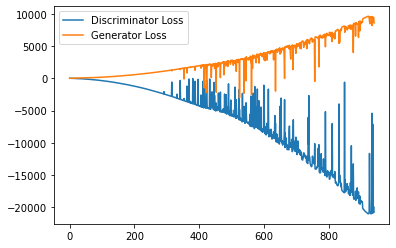

In [12]:
plt.figure()
plt.plot(dlosses[:], label="Discriminator Loss")
plt.plot(glosses[:], label="Generator Loss")
plt.legend()